In [1]:
from skimage.io import imshow # For testing
from functools import partial
from time import perf_counter
import pandas as pd
import numpy as np
import random
import h5py
import os

import matplotlib.pyplot as plt
import seaborn

In [2]:
# Define path names here
image_path_prefix = 'data/Category and Attribute Prediction Benchmark/Img/Img/'
image_to_category = 'data/Category and Attribute Prediction Benchmark/Anno/list_category_img.txt'
img_net_class_path = 'data/ImageNetClasses/imagenet1000_clsid_to_human.txt'
deep_fash_class_path = 'data/Category and Attribute Prediction Benchmark/Anno/list_category_cloth.txt'

n_images_loaded = -1 # -1 loads all

In [3]:
## Class for managing reading and writing data in chunks
from skimage.io import imread # uses PIL on the backend
from skimage.io import imsave

# Needed to apply preprocessing to labels. 
# I don't like introducing model dependent processing to Labels.
# Consider simplifying __next__ and transferring responsibiility elsewhere
from keras.applications.resnet50 import preprocess_input as res_preproc
from keras.applications.inception_v3 import preprocess_input as inc_preproc
from keras.applications.xception import preprocess_input as xcept_preproc

class Labels():
    """
    Manages saving and loading for all data
    """
    def __init__(self,labels_info,image_path_prefix):
        self.n_top_labels = 10 # n most frequent labels
        self.image_path_prefix = image_path_prefix
        self.iter_df = True
        if isinstance(labels_info,str):
            self.labels = self._determine_data_subset(labels_info,self.n_top_labels)
            
            # Reduce image_paths to their base form
            self.labels['image_name'] = self.labels['image_name'].apply(lambda x: x[len('img'):-len('.jpg')])
        elif isinstance(labels_info,pd.DataFrame):
            self.labels = labels_info
        else:
            raise ValueError('Unknown data type for labels_info')

    def __len__(self):
        return len(self.labels)

    def __next__(self):
        """
        Returns image data and corresponding category information
        
        set_load_target must be called first. Note that the labels 
        may be iterated over forever - the data loops upon reaching
        the end of the label list.
        """
        if self.i_chunk == self.n_chunk:
            self.i_chunk = 0
        subset = self.labels.iloc[self.i_chunk*self.chunksize:(self.i_chunk+1)*self.chunksize,:]
        subset['data'] = subset['image_name'].apply(self._load_data)
        self.i_chunk += 1
        if self.iter_df:
            return subset
        else:
            # This form is most convenient when feeding to models
            subset['data'] = subset['data'].apply(self.preproc_data)
            return np.stack(subset['data'].values), np.stack(subset['category_label'].values)
    
    @staticmethod
    def _determine_data_subset(labels_path,n_top_labels):
        # Read in the attribute information to figure out what images to load
        cat_labels = pd.read_csv(labels_path,skiprows=1,sep='\s+')
        
        # Figure out which are the most frequent labels to keep
        cat_label_count = cat_labels.groupby('category_label').count()
        cat_label_count = cat_label_count.sort_values(by=['image_name'],ascending=False)
        kept_labels = cat_label_count.head(n_top_labels).index
    
        # Filter labels not in the n_top_labels most frequent
        cat_labels = cat_labels.loc[cat_labels['category_label'].isin(kept_labels)]
    
        if n_images_loaded != -1:
            return cat_labels.head(n_images_loaded)
        else:
            return cat_labels
        
    def one_hot_labels(self):
        """
        One hot encode category label entries, creating a map from their label to 
        one hot encoded index
        """
        self.cat_map = {}
        unique_list = self.labels['category_label'].unique()
        for i, cat in enumerate(unique_list):
            self.cat_map[cat] = i
        
        def one_hot_encode(category):
            ohe = np.zeros(self.n_top_labels)
            ohe[self.cat_map[category]] = 1
            return ohe
        self.labels['category_label'] = self.labels['category_label'].apply(one_hot_encode)
        
    def set_data_target(self,target,chunksize,model_name=''):
        """Set the type of data, how much of it to load, and how to save it"""
        load_method_dict = { 
            'raw_image' : self._load_raw_image,
            'proc_image' : self._load_proc_image,
            'bottleneck' : partial(self._load_bottleneck,model_name),
        }
        save_method_dict = {
            'raw_image' : self._save_proc_image,
            'proc_image' : partial(self._save_bottleneck,model_name),
            'bottleneck' : partial(self._save_predictions,model_name),
        }
        self._load_data = load_method_dict[target]
        self._save_data = save_method_dict[target]
        
        self.chunksize = chunksize
        self.i_chunk = 0
        self.n_chunk = (len(self.labels) + chunksize - 1)//chunksize
        self.load_target = model_name+' '+target
        self.set_preprocessing(model_name)
        self.target = target
        
    def _set_preprocessing(self,model_name):
        """
        Set the type of preprocessing applied to data before it is returned by
        __next__. Only used when data target is "bottleneck" 
        """
        preproc_dict = {
            'resnet' : res_preproc,
            'inception_v3' : inc_preproc,
            'xception' : xcept_preproc,
        }
        self.preproc_data = preproc_dict.get(model_name,lambda x: x)
        
    def save(self,subset_df):
        subset_df.apply(self._save_data,axis=1)
    
    def _load_raw_image(self,image_path):
        """Given an image path, load the data as an array"""
        load_path = self.image_path_prefix+'img'+image_path+'.jpg'
        image = imread(load_path,plugin='pil')
        return image

    def _save_proc_image(self,row):
        save_path = self.image_path_prefix+'proc_img'+row['image_name']+'.jpg'
        imsave(save_path,row['data'],plugin='pil')
    
    def _load_proc_image(self,image_path):
        """Given an image path, load the data as an array"""
        load_path = self.image_path_prefix+'proc_img'+image_path+'.jpg'
        image = imread(load_path,plugin='pil')
        return image

    def _save_bottleneck(self,model_name,row):
        save_path = self.image_path_prefix+model_name+'_bottleneck'+row['image_name']+'.npy'
        np.save(save_path,row['data'])

    def _load_bottleneck(self,model_name,numpy_path):
        """Given a numpy path, load the data as an array"""
        load_path = self.image_path_prefix+model_name+'_bottleneck'+numpy_path+'.npy'
        bottleneck = np.load(load_path)
        return bottleneck
    
    def _save_predictions(self,model_name,row):
        pass

# Data Preprocessing

In [4]:
from skimage.transform import rescale

def preprocess_data(img_df):
    img_df['data'] = scale_images(img_df['data'])
    img_df['data'] = fill_image(img_df['data'])
    return img_df

def scale_images(image_series):
    """
    Scale images so first dimension is 224 for input to ImageNet
    """
    def first_dim_224(img):
        """Scale first dimension of image to 224 pixels"""
        height = img.shape[0]
        return rescale(img,224/height,mode='constant')
    rescaled = image_series.apply(first_dim_224)
    return rescaled

def fill_image(image_series):
    """
    Pad second dimension of images with black or crop until length 224 reached
    """
    def pad_with_black(img):
        """
        If image's x dim is less than 224 pixels pad with black. If too large crop to 224.
        Modification spread evenly across both sides.
        """
        pix_to_pad = 224 - img.shape[1]
        if pix_to_pad < 0:
            # Crop the image
            pix_to_crop = -pix_to_pad
            img = img[:,pix_to_crop//2:-((pix_to_crop+1)//2),:]
        else:
            # Pad the image
            img = np.pad(img,[(0,0),((pix_to_pad+1)//2,pix_to_pad//2),(0,0)],mode='constant')
        return img
    padded = image_series.apply(pad_with_black)
    return padded

In [5]:
## Save processed images to disk as jpeg
chunksize = 2

# Takes about 30 min to calculate all
start = perf_counter(); image_count = 0
labels = Labels(image_to_category,image_path_prefix)
labels.set_data_target('raw_image',chunksize)

for i in range(labels.n_chunk):
    img_df = next(labels)
    print(labels.i_chunk)
    img_df = preprocess_data(img_df)
    labels.save(img_df)
    
    image_count += len(img_df)
    print('Chunk {} of {} complete'.format(labels.i_chunk,labels.n_chunk))
print('Took {} seconds to preprocess {} images'.format(perf_counter() - start,image_count))

/Sheer_Pleated-Front_Blouse/img_00000001
/Sheer_Pleated-Front_Blouse/img_00000002
1
Chunk 1 of 25 complete
/Sheer_Pleated-Front_Blouse/img_00000003
/Sheer_Pleated-Front_Blouse/img_00000004


/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

2
Chunk 2 of 25 complete
/Sheer_Pleated-Front_Blouse/img_00000005
/Sheer_Pleated-Front_Blouse/img_00000006
3
Chunk 3 of 25 complete
/Sheer_Pleated-Front_Blouse/img_00000007
/Sheer_Pleated-Front_Blouse/img_00000008
4
Chunk 4 of 25 complete
/Sheer_Pleated-Front_Blouse/img_00000009
/Sheer_Pleated-Front_Blouse/img_00000010
5
Chunk 5 of 25 complete
/Sheer_Pleated-Front_Blouse/img_00000011
/Sheer_Pleated-Front_Blouse/img_00000012
6
Chunk 6 of 25 complete
/Sheer_Pleated-Front_Blouse/img_00000013
/Sheer_Pleated-Front_Blouse/img_00000014
7
Chunk 7 of 25 complete
/Sheer_Pleated-Front_Blouse/img_00000015
/Sheer_Pleated-Front_Blouse/img_00000016
8
Chunk 8 of 25 complete
/Sheer_Pleated-Front_Blouse/img_00000017
/Sheer_Pleated-Front_Blouse/img_00000018
9
Chunk 9 of 25 complete
/Sheer_Pleated-Front_Blouse/img_00000019
/Sheer_Pleated-Front_Blouse/img_00000020
10
Chunk 10 of 25 complete
/Sheer_Pleated-Front_Blouse/img_00000021
/Sheer_Pleated-Front_Blouse/img_00000022
11
Chunk 11 of 25 complete
/Sheer_P

In [9]:
# Handle storing data to HDF5 here. Need special treatment due to numpy arrays
def store_to_hdf5(hdfstore,img_df,i_chunk):
    img_df[['image_name','category_label']].to_hdf(hdfstore,'chunk{}/info'.format(i_chunk))
    
    hdfstore.put('chunk{}/image'.format(i_chunk),pd.DataFrame(
        img_df['image'].apply(lambda x: np.ravel(x)).values
    ))

In [10]:
# Load and preprocess the image data
# Broke at chunksize 500 at chunk 197
chunksize = 1500 # Field becomes too large to store if this goes much higher

# Clear the stored file if it already exists
if os.path.exists(proc_img_path):
    os.remove(proc_img_path)

start = perf_counter(); image_count = 0
with pd.HDFStore(proc_img_path,'a',complevel=9) as proc_img_hdf:
    i_chunk = 0
    for n_chunk, img_df in load_data(image_to_category,chunksize):
        img_df = preprocess_data(img_df)
        store_to_hdf5(proc_img_hdf,img_df,i_chunk)
#        img_df.to_hdf(proc_img_hdf,'image/chunk{}'.format(i_chunk))

        image_count += len(img_df)
        i_chunk += 1
        print('Chunk {} of {} complete'.format(i_chunk,n_chunk))
    proc_img_hdf.get_node('image')._f_setattr('chunksize',chunksize)
print('Took {} seconds to preprocess {} images'.format(perf_counter() - start,image_count))

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

Chunk 1 of 193 complete
Chunk 2 of 193 complete
Chunk 3 of 193 complete
Chunk 4 of 193 complete
Chunk 5 of 193 complete
Chunk 6 of 193 complete
Chunk 7 of 193 complete
Chunk 8 of 193 complete
Chunk 9 of 193 complete
Chunk 10 of 193 complete
Chunk 11 of 193 complete
Chunk 12 of 193 complete
Chunk 13 of 193 complete
Chunk 14 of 193 complete
Chunk 15 of 193 complete
Chunk 16 of 193 complete
Chunk 17 of 193 complete
Chunk 18 of 193 complete
Chunk 19 of 193 complete
Chunk 20 of 193 complete
Chunk 21 of 193 complete
Chunk 22 of 193 complete
Chunk 23 of 193 complete
Chunk 24 of 193 complete
Chunk 25 of 193 complete
Chunk 26 of 193 complete
Chunk 27 of 193 complete
Chunk 28 of 193 complete
Chunk 29 of 193 complete
Chunk 30 of 193 complete
Chunk 31 of 193 complete
Chunk 32 of 193 complete
Chunk 33 of 193 complete
Chunk 34 of 193 complete


KeyboardInterrupt: 

# Descriptive Info

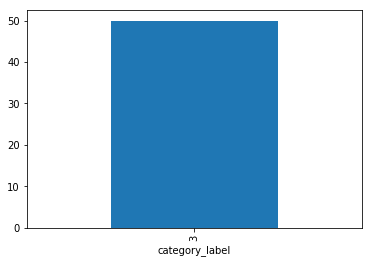

In [7]:
# Categories by number of occurences in img_df
labels.labels.groupby('category_label')['image_name'].count().sort_values(ascending=False).plot(kind='bar')
plt.show()

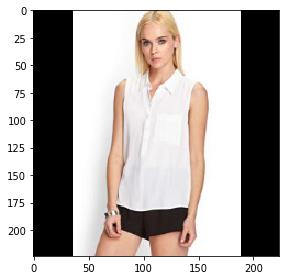

In [15]:
# Shows images from the last images to be processed
imshow(img_df['data'].iloc[random.randint(0,img_df.shape[0]-1)])
plt.show()

# Baseline Statistics

In [1]:
# Declare the ImageNet models we'll use as  a baseline
from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

# define ResNet50 model
res50 = ResNet50(weights='imagenet')
#vgg19 = VGG19(weights='imagenet')
incv3 = InceptionV3(weights='imagenet')
xcept = Xception(weights='imagenet')

model_dict = {
        'resnet' : res50,
#        'vgg19' : vgg19,
        'inception_v3' : incv3,
        'xception' : xcept,
    }

Using TensorFlow backend.


The DeepFashion dataset assigns one clothing category to each image, even if more articles of clothing are visible. To account for this, when predicting we take the most likely category as the sole image category. 

When comparing ImageNet predictions to DeepFashion predictions, category names are matched by hand. However, not all categories have a reasonable counterpart. For this reason we calculate accuracy considering only those categories that can be matched. More explicitly: 
- We exclude all images from the DeepFashion dataset that do not have at least one ImageNet category corresponding to their true category
- When calculating the most probable ImageNet category, we only take the max probability across ImageNet categories that can be matched to a DeepFashion category
- A prediction is always made - no matter how low the category probability 

In [17]:
## Generate some statistics on how ImageNet models with no tuning perform on the DeepFashion dataset
def generate_baseline_stats(img_df):
    """
    Generates a report on the baseline performance of a pre-trained ImageNet classifier
    """
    # Map of the ImageNet labels to DeepFashion labels
    # Determined by crossreferencing:
    #     https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
    # with the DeepFashion category labels which match the (1 based) index as listed in: 
    #      data/Category and Attribute Prediction Benchmark/Anno/list_category_cloth
    # Top 10 IDs: 41, 18, 3, 32, 17, 33, 6, 16, 11, 19
    # The associations are not perfect, they will be evaluated individually later
    img_net_to_deep_fash_names = {
        'overskirt' : ['Dress'], # ?
        'hoopskirt, crinoline' : ['Dress'], # ?
        'jersey, T-shirt, tee shirt' : ['Tee','Blouse'], # OK, ?
#        : 'Shorts',
#        : 'Tank',
        'miniskirt, mini' : ['Skirt'], # OK
#        : 'Cardigan',
        'sweatshirt' : ['Sweater'], # ?
#        : 'Jacket',
#        : 'Top', # Too diverse - may want to drop entirely
    }
    img_net_to_deep_fash_id = build_id_map(img_net_to_deep_fash_names)
    
    # Only predict on images with a category ImageNet models can predict
    valid_ids = [ id_ + 1 for id_list in img_net_to_deep_fash_id.values() for id_ in id_list ]
    relevant_img_df = img_df.loc[img_df['category_label'].isin(valid_ids),:]


    # Get the prediction accuracy with each of the models in model_dict below
    image_net_predict(img_net_to_deep_fash_id,model_dict,relevant_img_df)
    acc_dict = calc_accuracy(img_net_to_deep_fash_id,model_dict,relevant_img_df)
    return acc_dict
    
def image_net_predict(id_map,model_dict,img_df):
    """"""
    for name, model in model_dict.items():
        start = perf_counter()
        preds = model.predict(np.stack(img_df['image'].values))
        print('{} took {} seconds to predict {} images'.format(name,perf_counter() - start,len(preds)))
        img_df[name] = get_img_net_cat(preds,id_map)

def get_img_net_cat(preds,id_map):
    # Get just the predictions for categories that map to DeepFashion categories
    valid_cat_ids = list(id_map.keys())
    preds = preds[:,valid_cat_ids]
    
    # Get the most probable index as indexed in the full ImageNet category list
    max_indices = np.argmax(preds,axis=1)
    max_indices = [ valid_cat_ids[ind] for ind in max_indices ]
    return max_indices

def calc_accuracy(id_map,model_dict,img_df):
    def get_outcome(model_name,row):
        pred = id_map[row[model_name]]
        if row['category_label'] - 1 in pred:
            return 1
        return 0
    acc_dict = {}
    for name in model_dict.keys():
        acc_dict[name] = sum(img_df.apply(partial(get_outcome,name),axis=1))/img_df.shape[0]
    return acc_dict

def build_id_map(name_map):
    # Get ImageNet ID to name map. IDs start at 0
    with open(img_net_class_path) as class_def:
        img_net_dict = eval(''.join(list(class_def)))
    
    # Get DeepFashion ID to name map. IDs start at 0
    deep_fash_dict = pd.read_csv(deep_fash_class_path,
                    skiprows=1,sep='\s+',usecols=['category_name']).to_dict()['category_name']
    
    # Reverse the dictionaries
    img_net_dict = { val : key for key, val in img_net_dict.items() }
    deep_fash_dict = { val : key for key, val in deep_fash_dict.items() }

    net_id_to_fash_id = {}
    for k,v in name_map.items():
        for name in v:
            try:
                net_id_to_fash_id[img_net_dict[k]].append(deep_fash_dict[name])
            except (KeyError,AttributeError):
                net_id_to_fash_id[img_net_dict[k]] = [deep_fash_dict[name]]
    return net_id_to_fash_id

In [ ]:
generate_baseline_stats(img_df)

Given the results above, I think my chosen mapping may not be that accurate. The chosen models have well over 80% accuracy on the ImageNet dataset. Numbers as low as those reported above signals a problem with the data, likely the choice of corresponding classes is not the best. 

# Bottleneck Feature Calculation

In [ ]:
# Unused, better to pick last frozen layer by hand

def first_frozen_layer(base_model,unfrozen_layers):
    """
    Returns the layer just before the first unfrozen layer, the output node index 
    and inbound node index for that layer. 
    Unfrozen layers only counts layers with trainable weights. 
    base_model - The model with layers we want to freeze
    unfrozen_layers - The number of trainable layers to skip before the target layer
    """
    unfrozen_count = 0 # -1 because we want one more than the unfrozen_layers
    # Get the name of the first layer to be left frozen
    for l_num in range(len(base_model.layers_by_depth)):
        if unfrozen_count == unfrozen_layers:
            break
        for layer in base_model.layers_by_depth[l_num]:
            if layer.weights:
                unfrozen_count += 1
                if unfrozen_count == unfrozen_layers:
                    target_index = get_target_index(l_num,base_model.layers_by_depth)
                    in_node, out_node = get_node_indices(target_index,base_model.layers_by_depth)
                    break
        
    try:
        return target_index, in_node, out_node
    except NameError:
        print('Error: All layers or more layers than the network has left unfrozen')
        raise(AssertionError)
        
def get_target_index(l_num,layer_dict):
    """Gets the layer index before the layer at l_num"""
    l_num += 1
    # Avoid multiple layer entries, complicates implementation
    while len(layer_dict[l_num]) != 1:
        l_num += 1
    return l_num
        
def get_node_indices(layer_key, layer_dict):
    """Making sure we get the right input and output nodes for the layer"""
    # Will complete implementation if necessary. Will be difficult to handle edge cases right
    return -1, 0

    target_layer = layer_dict[layer_key]
    if len(target_layer.outbound_nodes) == 1:
        out_ind = 0
    else:
        # Scan to end of network for first matching node
        out_ind = -1
        cur_ind = layer_key - 1
        while cur_ind >= 0:
            for layer in layer_dict[cur_ind]:
                for node in layer.inbound_nodes:
                    if node in target_layer.outbound_nodes:
                        out_ind = target_layer.outbound_nodes.index(node)
            if out_ind != -1:
                break
            cur_ind -= 1
    
    if len(target_layer.inbound_nodes) == 1:
        in_ind = 0
    else:
        # Scan to end of network for first matching node
        in_ind = -1
        cur_ind = layer_key + 1
        while cur_ind < len(layer_dict):
            for layer in layer_dict[cur_ind]:
                for node in layer.outbound_nodes:
                    if node in target_layer.inbound_nodes:
                        in_ind = target_layer.inbound_nodes.index(node)
            if in_ind != -1:
                return in_ind, out_ind
            cur_ind += 1
        in_ind = 0
    return in_ind, out_ind

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

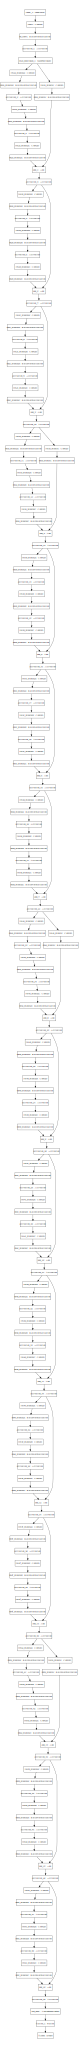

In [19]:
## Resnet visualization
SVG(model_to_dot(res50).create(prog='dot', format='svg'))

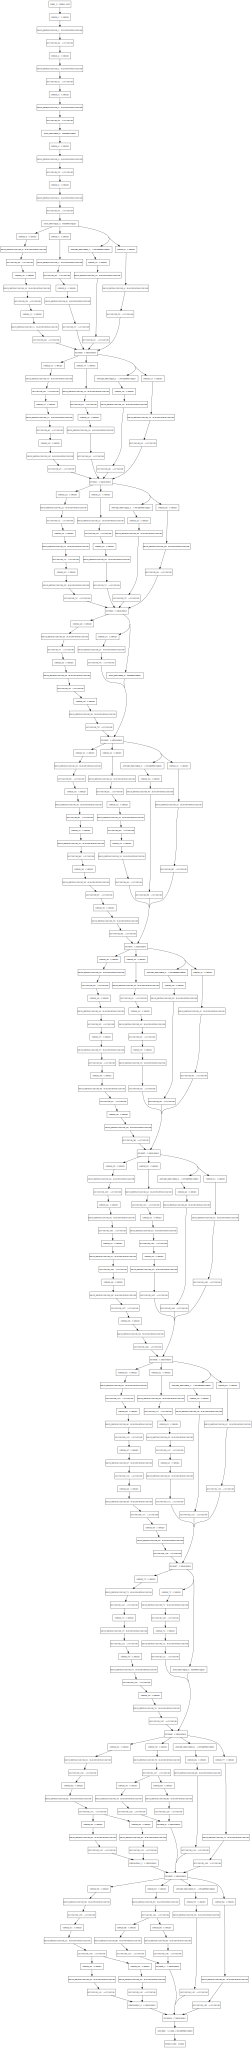

In [17]:
## Inception V3 visualization
SVG(model_to_dot(incv3).create(prog='dot', format='svg'))

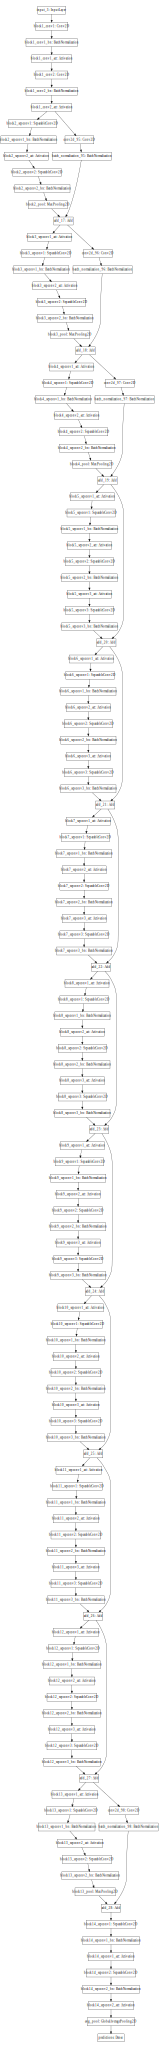

In [18]:
## Xception visualization
SVG(model_to_dot(xcept).create(prog='dot', format='svg'))

In [5]:
from keras.models import Model
from keras.applications.resnet50 import preprocess_input as res_preproc
from keras.applications.inception_v3 import preprocess_input as inc_preproc
from keras.applications.xception import preprocess_input as xcept_preproc

# Output layers chosen to be near output layer and at a 
# point where tensor flows converge
# WARNING: Fragile. Must load models only once in order above
max_layer_dict = {
    'resnet' : 'activation_46',
    'inception_v3' : 'mixed9',
    'xception' : 'add_28',
    }
def create_bottleneck_model(model,model_name):
    output_layer = model.get_layer(max_layer_dict[model_name])
    return Model(model.input,output_layer.output)

def calc_bottleneck_features(labels,model_name,bottleneck_model):
    """Calculate bottleneck features in chunks"""
    for i in range(labels.n_chunk):
        img_df = next(labels)
        img_df['data'] = img_df['data'].apply(partial(normalize_image_vals,model_name))
        bot_feats = bottleneck_model.predict(np.stack(img_df['data'].values))
        img_df['data'] = [ a for a in bot_feats ]
        yield img_df
        
def normalize_image_vals(name,image):
    """Preprocess loaded images for feeding into pretrained imagenet models"""
    preproc_dict = {
        'resnet' : res_preproc,
        'inception_v3' : inc_preproc,
        'xception' : xcept_preproc,
    }
    image = preproc_dict[name](image.astype(np.float64))
    return image

In [47]:
## Generate bottleneck features and store them
chunksize = 2

labels = Labels(image_to_category,image_path_prefix)

# Output from below roughly 90 GB, may need to run one at a time and transfer to different storage
#models_to_run = [ 'resnet', 'inception_v3'] # Took 1449.48 s and 1179.66 s
#models_to_run = ['xception'] # Took 1546.35 s
models_to_run = [ 'resnet', 'inception_v3','xception']
for name in models_to_run:
    model = model_dict[name]
    bottleneck_model = create_bottleneck_model(model,name)
    
    start = perf_counter()
    labels.set_data_target('proc_image',chunksize,name)
    for bot_feat_df in calc_bottleneck_features(labels,name,bottleneck_model):
        labels.save(bot_feat_df)
        
        print('Chunk {} of {} complete'.format(labels.i_chunk,labels.n_chunk))
    print('Took {} seconds to calculate {} bottleneck features for {}'
          .format(perf_counter() - start,len(labels),name))

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

Chunk 1 of 25 complete
Chunk 2 of 25 complete
Chunk 3 of 25 complete
Chunk 4 of 25 complete
Chunk 5 of 25 complete
Chunk 6 of 25 complete
Chunk 7 of 25 complete
Chunk 8 of 25 complete
Chunk 9 of 25 complete
Chunk 10 of 25 complete
Chunk 11 of 25 complete
Chunk 12 of 25 complete
Chunk 13 of 25 complete
Chunk 14 of 25 complete
Chunk 15 of 25 complete
Chunk 16 of 25 complete
Chunk 17 of 25 complete
Chunk 18 of 25 complete
Chunk 19 of 25 complete
Chunk 20 of 25 complete
Chunk 21 of 25 complete
Chunk 22 of 25 complete
Chunk 23 of 25 complete
Chunk 24 of 25 complete
Chunk 25 of 25 complete
Took 23.696786756976508 seconds to calculate 50 bottleneck features for resnet
Chunk 1 of 25 complete
Chunk 2 of 25 complete
Chunk 3 of 25 complete
Chunk 4 of 25 complete
Chunk 5 of 25 complete
Chunk 6 of 25 complete
Chunk 7 of 25 complete
Chunk 8 of 25 complete
Chunk 9 of 25 complete
Chunk 10 of 25 complete
Chunk 11 of 25 complete
Chunk 12 of 25 complete
Chunk 13 of 25 complete
Chunk 14 of 25 complete
Chu

In [ ]:
with pd.HDFStore('intermediates/bottleneck_feats.hdf5','w') as feat_store:
    feat_store.append('labels',img_df[['image_name','category_label']])
    for name, model in model_dict.items():
        # A max of 5 trainable layers back from output will be trained
        out_index, in_node, out_node = first_frozen_layer(model,5)
        bottleneck_model = Model(inputs=model.input,outputs=model.layers_by_depth[out_index][0].get_output_at(out_node))
        
        # Break into batches over images here if necessary
        start = perf_counter()
        bottleneck_feats = bottleneck_model.predict(np.stack(img_df['image'].values))
        print('{} took {} seconds to generate {} feature sets'.format(name,perf_counter() - start,len(bottleneck_feats)))
        # all are 4D arrays, will need to find a more robust storage method if that changes
        feat_store.append('feat_data/'+name,pd.Panel4D(bottleneck_feats))

# Hyperparameter Optimization

Now a model tuned to the DeepFashion dataset will be trained. The considered hyperparameters will
be:
- Transfer learning base: Resnet, Inception V3, Xception
- Layer at which to unfreeze weights
- Epoch to stop training

In [7]:
## Transfer learning utilities
# These routines allow a layer from farther back in a model to be replaced 
# with an input layer so precalculated bottleneck features can be fed in
from keras.models import clone_model
from keras.models import Model
from keras.layers import Dense, InputLayer

def sub_in_layer(model,sub_out_name,sub_in_layer):
    """
    Replaces a node with an input layer and updates the model graph to reflect that
    change. Currently does not remove references to replaced nodes - prevents rerunning.
    Unable to handle layers with mulitple inbound_nodes. 
    """
    head_dict = { sub_out_name : sub_in_layer.output } # Assumes one output
    sub_out_layer = model.get_layer(sub_out_name)
    out_node_list = [ node for node in sub_out_layer.outbound_nodes ]
    continue_loop = True
    while out_node_list and continue_loop:
        continue_loop = False
        for node in out_node_list[::-1]:
            modified = update_graph(model,head_dict,node,out_node_list)
            continue_loop = continue_loop | modified
        if not continue_loop:
            print('Could not find reference to inbound layer. This likely means'
                 ' output from a layer before the subbed-in layer is required. ')
    
def update_graph(model,head_dict,out_node,out_node_list):
    """Update graph layers to take output from tensors specified in head_dict"""
    if input_ref_present(out_node,head_dict):
        new_out_nodes = relink_graph(model,out_node,head_dict)
        out_node_list.remove(out_node)
        new_out_nodes = [node for node in new_out_nodes if node not in out_node_list]
        out_node_list += new_out_nodes
        return True
    return False

def input_ref_present(out_node,head_dict):
    return all( layer_name in head_dict.keys() 
               for layer_name in out_node.get_config()['inbound_layers'] )
                    
def relink_graph(model,out_node,head_dict):
    """
    Feed output of inbound_layers specified in out_node to the receiving layer. 
    Associate the receiving layer's name with its new output in head_dict. 
    Return the receiving layer's outbound nodes to continue relinking graph. 
    """
    new_link_name = out_node.get_config()['outbound_layer']
    new_link_layer = model.get_layer(new_link_name)
    if len(new_link_layer.inbound_nodes) > 1:
        raise NotImplementedError('Layer {} used in multiple places'.format(new_link_name)
                                  + ' (has multiple inbound_nodes). Unable to relink graph.')
    
    if len(out_node.get_config()['inbound_layers']) == 1:
        x = new_link_layer(head_dict[out_node.get_config()['inbound_layers'][0]])
    else:
        inbound_list = [ head_dict[l] for l in out_node.get_config()['inbound_layers'] ]
        x = new_link_layer(inbound_list)
    head_dict[new_link_name] = x
    return new_link_layer.outbound_nodes

def model_top_at_layer(model,layer_name):
    """
    Returns the part of model from layer layer_name until the output layer
    with layer layer_name replaced by an InputLayer
    """
    mod_cop = clone_model(model)
    mod_cop.set_weights(model.get_weights())
    
    inp = InputLayer(model.get_layer(layer_name).output_shape[1:])
    sub_in_layer(mod_cop,layer_name,inp)
    x = mod_cop.layers[-1].get_output_at(1)
    
    return Model(inp.input,x)

def replace_out_layer(model,num_outputs):
    """Replaces the last layer of a model with a dense layer with num_outputs outputs"""
    model.layers.pop()
    model.layers[-1].outbound_nodes = []
    
    new_layer = Dense(num_outputs,activation='softmax')
    new_out = new_layer(model.layers[-1].get_output_at(1))
    new_model = Model(model.input,new_out)
    return new_model

In [29]:
# Check model weights match
tmp_mod = model_top_at_layer(res50,'activation_46')

tmp_l = tmp_mod.get_layer('res5c_branch2b')
res_l = res50.get_layer('res5c_branch2b')

tmp_v = tmp_l.get_weights()
res_v = res_l.get_weights()

(tmp_v[0] == res_v[0]).all()

True

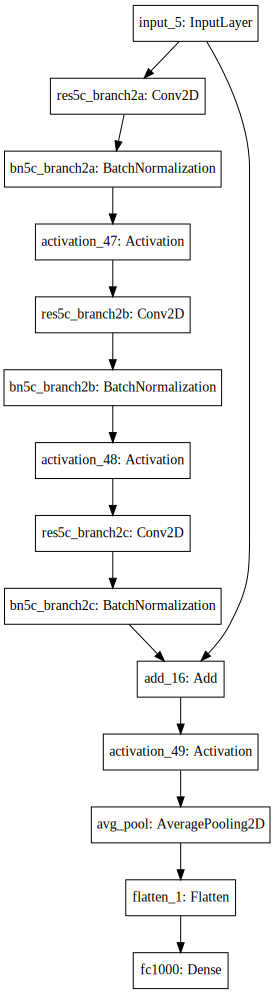

In [30]:
tmp_mod = model_top_at_layer(res50,'activation_46')
SVG(model_to_dot(tmp_mod).create(prog='dot', format='svg'))

In [35]:
# Test effect of casting to float16 and test bottleneck storing implementation

image_path = img_df.iloc[random.randint(0,len(img_df)-1),0]
img_sample = imread(image_path_prefix+'proc_img'+image_path+'.jpg',plugin='pil')
img_sample = res_preproc(img_sample.astype(np.float64))
img_sample = np.stack([img_sample])
bottle_sample = np.load(image_path_prefix+'resnet_bottleneck'+image_path+'.npy')
bottle_sample = np.stack([bottle_sample])

def calc_bottleneck(img_sample):
    model = Model(res50.input,res50.get_layer('activation_46').output)
    bottle = model.predict(img_sample)
    return bottle
true_bottle = calc_bottleneck(img_sample)
print('Absolute difference between float16 and float64 features:',abs(true_bottle - bottle_sample).sum())

img_pred = res50.predict(img_sample)
bot_pred = tmp_mod.predict(bottle_sample)
true_bot_pred = tmp_mod.predict(true_bottle)

print('Absolute difference in prediction from image and float16 bottleneck features:',abs(img_pred - bot_pred).sum())
print('Absolute difference in prediction from image and float64 bottleneck features:',abs(img_pred - true_bot_pred).sum())

Absolute difference between float16 and float64 features: 116.656
Absolute difference in prediction from image and float16 bottleneck features: 0.00353521
Absolute difference in prediction from image and float64 bottleneck features: 0.0


In [8]:
## Functions used in optimizing model hyperparameters
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import InputLayer

def stratified_train_val_test(y):
    """Generate stratified train-val-test splits. Hard coded for 70-20-10 proportion"""
    # Train-test split
    sss = StratifiedShuffleSplit(n_splits=1,test_size=.1)
    train, test = next(sss.split(y,y))
    
    # Train-validate split
    sss = StratifiedShuffleSplit(n_splits=1,test_size=2/9)
    train, valid = next(sss.split(y[train],y[train]))
    return train, valid, test

def subset_labels(indices,labels,chunksize,name):
    sub_labels = Labels(labels.labels.iloc[indices,:],labels.image_path_prefix)
    sub_labels.set_data_target('bottleneck',chunksize,name)
    sub_labels.iter_df = False
    return sub_labels

def optimize_model(model,name,train_labels,valid_labels,chunksize,max_epochs=5):
    # Output layer gets tuned first
    history_list = []
    if not os.path.exists('intermediates/saved_models/{}_tuned_out_layer.hdf5'.format(name)):
        checkpointer = ModelCheckpoint(
                filepath='intermediates/saved_models/{}_tuned_out_layer.hdf5'.format(name), 
                verbose=1, save_best_only=True)
        unfreeze_model(model,1)
        
        history = model.fit_generator(train_labels,
                    steps_per_epoch=train_labels.n_chunk,
                    epochs=75,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=valid_labels,
                    validation_steps=valid_labels.n_chunk,
                    )
        history_list.append(history)
        history_list.append(None)
        
    # Load pre-trained output layer weights
    model.load_weights('intermediates/saved_models/{}_tuned_out_layer.hdf5'.format(name))
    
    checkpointer = ModelCheckpoint(
                filepath='intermediates/saved_models/{}_base_weights.hdf5'.format(name), 
                verbose=1, save_best_only=True)
    max_unfrozen = count_max_frozen(model)
    for i_unfrozen in range(2,max_unfrozen+1):
        unfreeze_model(model,i_unfrozen)
        
        history = model.fit_generator(train_labels,
                    steps_per_epoch=train_labels.n_chunk,
                    epochs=max_epochs,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=valid_labels,
                    validation_steps=valid_labels.n_chunk,
                    )
        history_list.append(history)
        print('Model tuned with {} of {} layers unfrozen'.format(i_unfrozen,max_unfrozen))
    return history_list, test

def count_max_frozen(model):
    """Counts the total number of layers in model that have weights"""
    freeze_count = 0
    for layer in model.layers:
        if layer.weights:
            freeze_count += 1
    return freeze_count

def unfreeze_model(model,n_unfrozen):
    i_unfrozen = 0
    for layer in model.layers[::-1]:
        if layer.weights:
            layer.trainable = True
            i_unfrozen += 1
            if i_unfrozen == n_unfrozen:
                break
        
def prep_model(model,max_layer,depth):
    model_top = model_top_at_layer(model,max_layer)
    model_top = replace_out_layer(model_top,depth)
    for layer in model_top.layers:
        layer.trainable = False
    model_top.layers[-1].trainable = True
    model_top.compile('adam','categorical_crossentropy',metrics=['accuracy'])
    return model_top

In [ ]:
## Train the top of the model on the selected labels
from IPython.display import display
np.random.seed(313) # For reproducibility

chunksize = 3000
labels = Labels(image_to_category,image_path_prefix)
labels.one_hot_labels()
hist_dict = {}; test_indices = {}

models_to_run = [
    'resnet',
    'inception_v3',
    'xception',
]
for name in models_to_run:
    print('Fine tuning {} model'.format(name))
    model = model_dict[name]
    max_layer = max_layer_dict[name]
    model_top = prep_model(model,max_layer,depth=10)
    
    train, valid, test = stratified_train_val_test(np.stack(labels.labels['category_label'].values))
    train_labels = subset_labels(train,labels,chunksize,name)
    valid_labels = subset_labels(valid,labels,chunksize,name)
    test_indices[name] = test

    start = perf_counter()
    hist_dict[name] = optimize_model(model_top,name,train_labels,valid_labels,chunksize)
    print('Took {} seconds to optimize all layers for {}'
          .format(perf_counter() - start,name))
#    display(SVG(model_to_dot(model_top).create(prog='dot', format='svg')))

Fine tuning resnet model
Epoch 1/75


/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


54/54 [==============================] - 339s - loss: 1.7780 - acc: 0.4084 - val_loss: 2.0581 - val_acc: 0.3685
Epoch 2/75
54/54 [==============================] - 293s - loss: 1.3350 - acc: 0.5610 - val_loss: 1.4756 - val_acc: 0.5152
Epoch 3/75
54/54 [==============================] - 296s - loss: 1.2482 - acc: 0.5914 - val_loss: 1.2824 - val_acc: 0.5797
Epoch 4/75
54/54 [==============================] - 298s - loss: 1.2025 - acc: 0.6066 - val_loss: 1.2141 - val_acc: 0.6051
Epoch 5/75
54/54 [==============================] - 299s - loss: 1.1725 - acc: 0.6169 - val_loss: 1.1822 - val_acc: 0.6164
Epoch 6/75
54/54 [==============================] - 299s - loss: 1.1506 - acc: 0.6239 - val_loss: 1.1631 - val_acc: 0.6236
Epoch 7/75
54/54 [==============================] - 304s - loss: 1.1337 - acc: 0.6298 - val_loss: 1.1498 - val_acc: 0.6283
Epoch 8/75
54/54 [==============================] - 323s - loss: 1.1201 - acc: 0.6343 - val_loss: 1.1396 - val_acc: 0.6319
Epoch 9/75
54/54 [=========

In [9]:
dat_dict = {}
for name in models_to_run:
    dat_dict[name] = []
    for h in hist_dict[name]:
        if h:
            dat_dict[name].append(h.history)
        else:
            dat_dict[name].append(h)

AttributeError: 'list' object has no attribute 'history'

In [10]:
hist_dict

{'inception_v3': ([<keras.callbacks.History at 0x7f0cca444a58>,
   None,
  array([206724,  11423, 184412, ..., 100404, 202184, 223524])),
 'resnet': ([<keras.callbacks.History at 0x7f0cfc076fd0>,
   None,
  array([114280, 195689,  55142, ..., 205479, 105568,  17472])),
 'xception': ([<keras.callbacks.History at 0x7f0cd1d73ef0>,
   None,
  array([  7174, 130971, 195867, ..., 147094, 139704, 198048]))}

In [27]:
import pickle

with open('hist_ex','wb') as tmp:
    pickle.dump(dat_dict,tmp)